This block of the code enables us to unzip the given dataset and extract the 10 crucial classes for this assignment: "butterfly, cat, chicken, cow, dog, elefante, horse, sheep, spider, squirrel". After building this unzipping part of the code into a different cell, one time running is enough for our duty. After one running the files are set to be in our file hierarchy.

In [6]:
!unzip dataset.zip
%ls

Archive:  dataset.zip
   creating: dataset/
   creating: dataset/butterfly/
  inflating: dataset/butterfly/e030b20928e90021d85a5854ee454296eb70e3c818b413449df6c87ca3ed_640.jpg  
  inflating: dataset/butterfly/e030b20929e90021d85a5854ee454296eb70e3c818b413449df6c87ca3ed_640.jpg  
  inflating: dataset/butterfly/e030b2092be90021d85a5854ee454296eb70e3c818b413449df6c87ca3ed_640.jpg  
  inflating: dataset/butterfly/e030b2092ce90021d85a5854ee454296eb70e3c818b413449df6c87ca3ed_640.jpg  
  inflating: dataset/butterfly/e030b2092de90021d85a5854ee454296eb70e3c818b413449df6c87ca3ed_640.jpg  
  inflating: dataset/butterfly/e030b20a20e90021d85a5854ee454296eb70e3c818b413449df6c87ca3ed_640.jpg  
  inflating: dataset/butterfly/e132b60e2af51c22d2524518b7444f92e37fe5d404b0144390f8c770a3e5b7_640.jpg  
  inflating: dataset/butterfly/e134b50a2efc1c22d2524518b7444f92e37fe5d404b0144390f8c770a1edb6_640.jpg  
  inflating: dataset/butterfly/e830b30a20f5003ed1584d05fb1d4e9fe777ead218ac104497f5c97faee9bdba_640.png 

##Importing Necessary Libraries

In [17]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import itertools
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

###CNN Model Architecture Details:

In [2]:
class CNNClassifier(nn.Module):
    def __init__(self, dropout_rate=0.5):  # Add dropout_rate with a default value
        super(CNNClassifier, self).__init__()
        # Convolutional layers
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # First conv layer
            nn.ReLU(),
            nn.MaxPool2d(2),  # Max pooling after the first conv layer
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Second conv layer
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Third conv layer
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),  # Fourth conv layer
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # Fifth conv layer
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),  # Sixth conv layer
            nn.ReLU(),
            nn.MaxPool2d(2)  # Additional max pooling for reducing dimensionality
        )

        # Fully connected layers
        self.fc_layer = nn.Sequential(
            nn.Linear(256 * 56 * 56, 1024),  # First fully connected layer
            nn.ReLU(),
            nn.Dropout(dropout_rate),  # Use the dropout_rate parameter
            nn.Linear(1024, 10)  # Second fully connected layer; Assuming 10 classes
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layer
        x = self.fc_layer(x)
        return x


Initialize Model, Loss Function, and Optimizer

In [3]:
# Loss and optimizer
model = CNNClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

###Define the Accuracy Function

In [4]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


##Data Preparation
The data with data augmentation for the training set and normal transformation for the validation and test sets.

In [7]:
# Define transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Load dataset
dataset_path = './dataset'  # Update with your actual path
full_dataset = datasets.ImageFolder(dataset_path, transform=data_transforms['train'])

# Split dataset
train_size = int(0.7 * len(full_dataset))
validation_size = test_size = (len(full_dataset) - train_size) // 2
train_dataset, rest_dataset = random_split(full_dataset, [train_size, len(full_dataset) - train_size])
validation_dataset, test_dataset = random_split(rest_dataset, [validation_size, test_size])

train_dataset.dataset.transform = data_transforms['train']
validation_dataset.dataset.transform = data_transforms['val']
test_dataset.dataset.transform = data_transforms['val']

# Data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


###Train the Model
Defining a function for training and validation:

In [8]:
import torch.optim as optim

def train_and_validate(model, criterion, optimizer, train_loader, validation_loader, epochs=100):
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    best_acc = 0.0
    best_model_wts = model.state_dict()

    for epoch in range(epochs):
        # Training phase
        model.train()
        total_loss = 0
        total_correct = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            total_loss += loss.item() * inputs.size(0)
            total_correct += torch.sum(preds == labels.data).item()

        # Validation phase
        val_loss, val_acc = evaluate(model, criterion, validation_loader)
        history['train_loss'].append(total_loss / len(train_loader.dataset))
        history['train_acc'].append(total_correct / len(train_loader.dataset))
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()

    model.load_state_dict(best_model_wts)
    return model, history

def evaluate(model, criterion, data_loader):
    model.eval()
    total_loss = 0
    total_correct = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            total_loss += loss.item() * inputs.size(0)
            total_correct += torch.sum(preds == labels.data).item()
    return total_loss / len(data_loader.dataset), total_correct / len(data_loader.dataset)

model, history = train_and_validate(model, criterion, optimizer, train_loader, validation_loader, epochs=100)
#total_loss,total_correct = evaluate(model, criterion, data_loader)

###Graph of Loss and Accuracy Change
After training, use the history to plot the training and validation loss and accuracy:

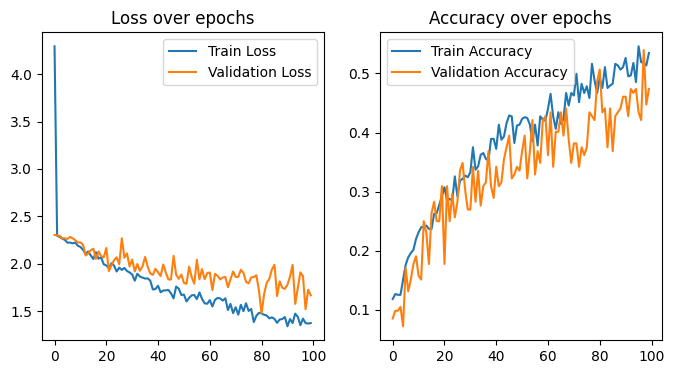

In [44]:
def plot_history(history):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss over epochs')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.legend()
    plt.show()

# Call the function to plot history
plot_history(history)

###Experimenting with Different Dropout Values
Modify the CNN model to include a configurable dropout, and train the model with different dropout rates:

In [28]:
dropout_rates = [0.1, 0.3, 0.5, 0.7]
for rate in dropout_rates:
    model = CNNClassifier(dropout_rate=rate)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model, history = train_and_validate(model, criterion, optimizer, train_loader, validation_loader, epochs=100)
    test_loss, test_acc = evaluate(model, criterion, test_loader)
    print(f'Dropout Rate: {rate}, Test Accuracy: {test_acc:.4f}, Validation Accuracy: {val_acc:.4f}')


###Test the Model and Visualize Results with Confusion Matrix
Finally, we should evaluate the model on the test set and visualize results such as the confusion matrix:

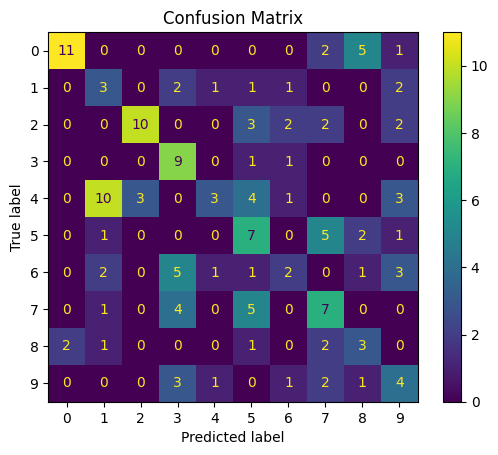

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move your model to the chosen device
model.to(device)

def plot_confusion_matrix(model, data_loader, device):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)  # Ensure inputs are on the same device as model
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())  # Move preds to CPU and convert to numpy
            all_labels.extend(labels.cpu().numpy())  # Move labels to CPU and convert to numpy

    # Generate confusion matrix using sklearn functionalities
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title('Confusion Matrix')
    plt.show()

# Assuming `test_loader` is already defined
plot_confusion_matrix(model, test_loader, device)

#PART 2: Transfer Learning with EfficientNet

**###Case 1: Training Only the FC Layer**


In [10]:
# Example Code to Freeze Layers and Train Only the Fully Connected Layer
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Assuming the fully connected layers are in a sequential block named `fc_layer`
for param in model.fc_layer.parameters():
    param.requires_grad = True

# Optimize only the parameters of the fully connected layers
optimizer = optim.Adam(model.fc_layer.parameters(), lr=0.001)

###Confusion Matrix for Case 1

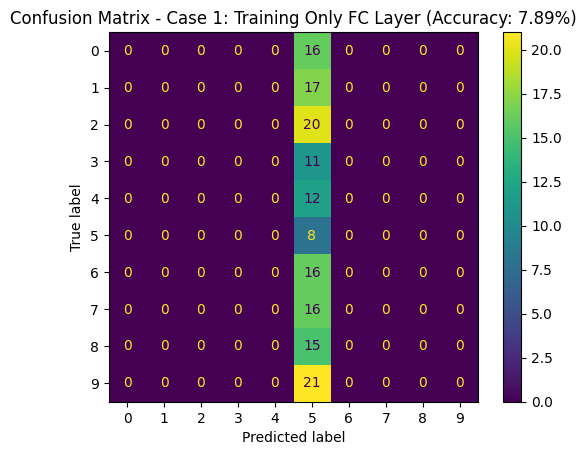

In [18]:
# Check if CUDA (GPU support) is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move your model to the chosen device
model.to(device)

# Assuming `history` has keys 'val_acc' that store validation accuracies
accuracy_case1 = max(history['val_acc']) * 100  # Multiply by 100 if you want it in percentage form

def plot_confusion_matrix_case1(model, test_loader, device, accuracy):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)  # Ensure inputs are on the same device as model
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())  # Move preds to CPU and convert to numpy
            all_labels.extend(labels.cpu().numpy())  # Move labels to CPU and convert to numpy

    # Generate confusion matrix using sklearn functionalities
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Confusion Matrix - Case 1: Training Only FC Layer (Accuracy: {accuracy:.2f}%)')
    plt.show()

# Call the function with the appropriate parameters
plot_confusion_matrix_case1(model, test_loader, device, accuracy_case1)

**###Case 2: Training the Last Two Convolutional Layers and FC Layer**

In [22]:
def unfreeze_model_layers(model):
    # Freeze all parameters first
    for param in model.parameters():
        param.requires_grad = False

    # Assuming the last two convolutional blocks and the fully connected layer are named accordingly
    # For example, model.features is your sequential model block
    # This part is pseudocode and needs to be adapted to your model's specific layer naming and structure
    if hasattr(model, 'features'):
        # Unfreeze the last two convolutional blocks
        for layer in list(model.features.children())[-2:]:
            for param in layer.parameters():
                param.requires_grad = True

    # Unfreeze the fully connected layers (assuming it's named 'fc_layer')
    for param in model.fc_layer.parameters():
        param.requires_grad = True

    return model

# Modify the optimizer to only optimize the unfrozen layers
def create_optimizer_for_unfrozen_layers(model, learning_rate=0.001):
    unfrozen_params = [param for param in model.parameters() if param.requires_grad]
    optimizer = optim.Adam(unfrozen_params, lr=learning_rate)
    return optimizer

# Assuming your model is already defined and moved to the appropriate device
model.to(device)
model = unfreeze_model_layers(model)
optimizer = create_optimizer_for_unfrozen_layers(model)

# Train and validate the model
model, history_case2 = train_and_validate(model, criterion, optimizer, train_loader, validation_loader, epochs=100)

# Assuming the best validation accuracy is what you need
accuracy_case2 = max(history_case2['val_acc']) * 100  # Convert to percentage

###Confusion Matrix for Case 2

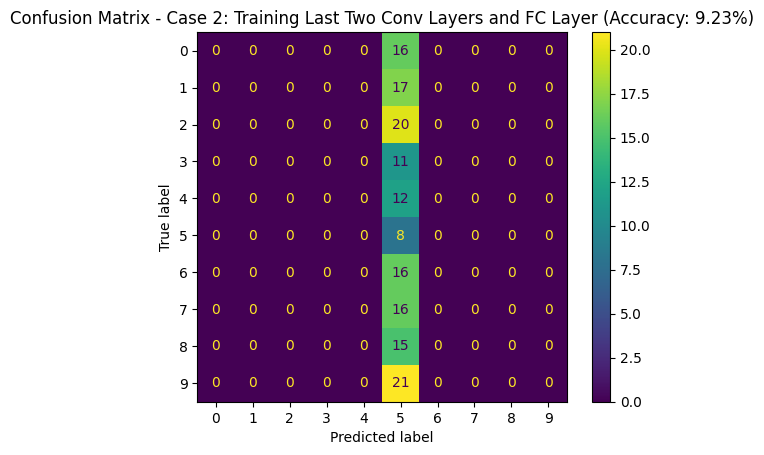

In [27]:
# Check if CUDA (GPU support) is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming `history_case2` has keys 'val_acc' that store validation accuracies
accuracy_case2 = max(history['val_acc']) * 100  # Multiply by 100 if you want it in percentage form


def plot_confusion_matrix_case2(model, test_loader, device, accuracy):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)  # Ensure inputs are on the same device as model
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())  # Move preds to CPU and convert to numpy
            all_labels.extend(labels.cpu().numpy())  # Move labels to CPU and convert to numpy

    # Generate confusion matrix using sklearn functionalities
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Confusion Matrix - Case 2: Training Last Two Conv Layers and FC Layer (Accuracy: {accuracy:.2f}%)')
    plt.show()

# Example usage, assuming all variables are defined
plot_confusion_matrix_case2(model, test_loader, device, accuracy_case2)
